# Crop DEM with point cloud boundaries

# import 

In [11]:
import geopandas as gpd
import py3dep
import rasterio
import os
import rioxarray
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from datetime import datetime

# functions

In [13]:
def download_3dep_dem(polygons_gdf, output_dir):
    """
    Downloads 3DEP 30m DEM data for given polygons and saves the data.

    Parameters:
    polygons_gdf (GeoDataFrame): The GeoDataFrame containing the polygons in EPSG:4326.
    output_dir (str): The directory to save the DEM data.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Check if polygons are in EPSG:4326
    if polygons_gdf.crs.to_string() != "EPSG:4326":
        raise ValueError("Polygons must be in EPSG:4326")
    
    error_msg = []
    total = polygons_gdf.shape[0]
    for i, (_, polygon) in enumerate(polygons_gdf.iterrows()):
        poly_name = polygon['name']
        out_dem_path = os.path.join(output_dir, f"{poly_name}_3dep30m.tif")
        if os.path.exists(out_dem_path):
            print(f'{poly_name}  exists, continue')
            continue
        if (i+1) % 1 == 0:
            print(f'{i+1}/{total}, {(i+1)/total*100:.2f}%, processing {poly_name}, {print_current_date_time()} ')
        try:
            geom = polygon['geometry']
            dem_data = py3dep.get_dem(geom, 30)
            # dem_data = py3dep.get_map("DEM", geom, resolution=30, geo_crs=4326, crs=3857)
            
            # Define the output path
            # polygon_name = polygon['name'].replace(" ", "_")  # Replace spaces with underscores for the file name
            
            # dem_data.rio.to_raster(out_dem_path, compress='LZW')
            dem_data.rio.to_raster(out_dem_path, compress='deflate') # better
    
            print(f"Saved DEM data: {out_dem_path}")
        except Exception as e:
            msg = f'Exception in processing {poly_name}: {e} \nso skipped'
            print(msg)
            error_msg.append(msg)
            continue


def print_current_date_time():
    # Get the current date and time
    now = datetime.now()

    # Format the date and time as a string
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")

    # Print the current date and time
    return "Current Date and Time:" + current_time



def visualize_raster(raster_path):
    """
    Reads and visualizes a raster file.

    Parameters:
    raster_path (str): The path to the raster file.
    """
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Read the data
        raster_data = src.read()
        print(src.crs)
        print(np.unique(raster_data))
        print(src.shape)
        # Plot the data
        plt.figure(figsize=(10, 10))
        # Check the number of bands
        if raster_data.shape[0] == 1:
            # Single-band raster
            show(raster_data, transform=src.transform, cmap='gray')
        elif raster_data.shape[0] == 3:
            # RGB raster
            show(raster_data, transform=src.transform)
        else:
            # Multiband raster, display the first band
            show(raster_data[0], transform=src.transform, cmap='gray')
        
        plt.title(f"Raster visualization of {raster_path}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()



# Cropping

In [4]:
boundary = gpd.read_file('../../data/point_cloud_boundary/20240627.topojson')
boundary = boundary.set_crs(epsg=4326, inplace=False)

In [12]:
# download
output_dir = '../../data/3DEP_30m_clip/'

# Load the polygons into a GeoDataFrame
polygons_gdf = boundary

# Download the 3DEP DEM data
download_3dep_dem(polygons_gdf, output_dir)

1/2118, 0.05%, processing AK_BrooksCamp_2012, Current Date and Time:2025-02-26 17:47:48 
Saved DEM data: ../../data/3DEP_30m_clip/AK_BrooksCamp_2012_3dep30m.tif
2/2118, 0.09%, processing AK_Coastal_2009, Current Date and Time:2025-02-26 17:48:04 



KeyboardInterrupt



# validation

EPSG:5070
[ 13.        13.000001  13.000002 ... 517.5542   519.69305         nan]
(830, 419)


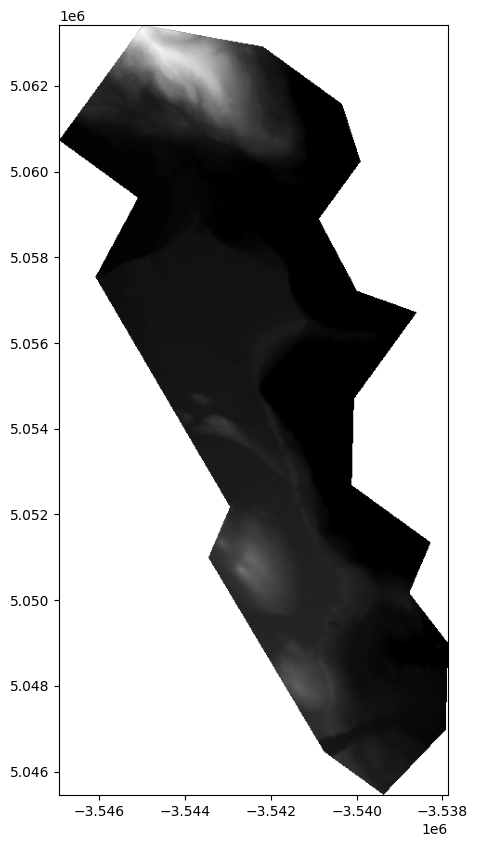

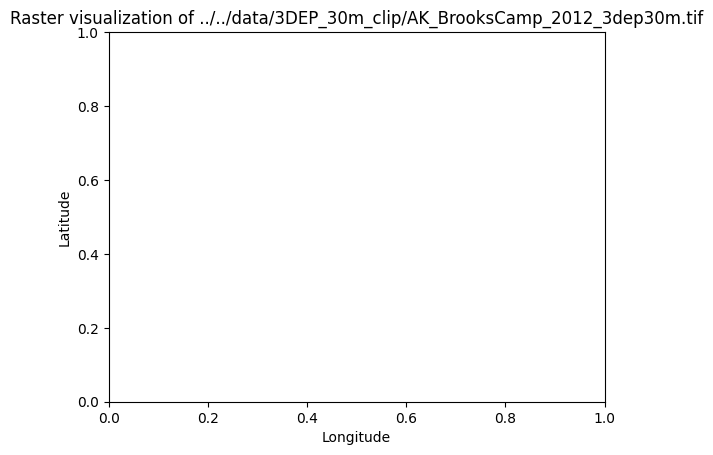

In [14]:
visualize_raster('../../data/3DEP_30m_clip/AK_BrooksCamp_2012_3dep30m.tif')